In [1]:
from dask_cloudprovider.aws import EC2Cluster
from dask.distributed import Client
import configparser
import os
import contextlib
import re
import dask
from platform import python_version

def get_aws_credentials():
    """Read in your AWS credentials file and convert to environment variables."""
    parser = configparser.RawConfigParser()

    parser.read(os.path.expanduser('~/.aws/config'))
    config = parser.items('default')

    parser.read(os.path.expanduser('~/.aws/credentials'))
    credentials = parser.items('default')

    all_credentials = {key.upper(): value for key, value in [*config, *credentials]}
    with contextlib.suppress(KeyError):
        all_credentials["AWS_REGION"] = all_credentials.pop("REGION")

    return all_credentials

# Pass in AWS Credentials + any extra packages you would like to install on cluster via `pip`
env_vars = get_aws_credentials()
env_vars["EXTRA_PIP_PACKAGES"] = "s3fs"

# Select software installed on scheduler + worker instances based on client Python + Dask versions
# versions need to match across client, scheduler, worker -- slight mismatches are OK, though
py_v = '-py' + re.findall(r'\d{1}.\d+', python_version())[0]
dask_docker_tag = f"daskdev/dask:{dask.__version__ + py_v}"
print('Docker Image: ', dask_docker_tag)

# launch a cluster of 5 r5.large instances (10 vCPUs):
# 1 scheduler
# 4 workers (2 threads + 16 GB RAM each)
cluster = EC2Cluster(instance_type='r5.large',
                     n_workers=4,
                     security=False,
                     docker_image=dask_docker_tag,
                     env_vars=env_vars
)

Docker Image:  daskdev/dask:2025.4.1-py3.13
Creating scheduler instance
Created instance i-03674edf6e0c00d5d as dask-03d64119-scheduler
Waiting for scheduler to run at 54.204.222.149:8786


KeyboardInterrupt: 

In [21]:
client = Client(cluster)
client # note that slight mismatches between client, scheduler, and worker software are fine

C:\Users\12112\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\distributed\client.py:1582: VersionMismatchWarning: Mismatched versions found

+---------+----------------+-----------------+---------+
| Package | Client         | Scheduler       | Workers |
+---------+----------------+-----------------+---------+
| lz4     | None           | 4.4.4           | None    |
| python  | 3.11.9.final.0 | 3.11.12.final.0 | None    |
| toolz   | 1.0.0          | 0.12.0          | None    |
+---------+----------------+-----------------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


Connection method: Cluster object,Cluster type: dask_cloudprovider.EC2Cluster
Dashboard: http://54.173.114.187:8787/status,
Dashboard: http://54.173.114.187:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.31.91.15:8786,Workers: 0
Dashboard: http://172.31.91.15:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [77]:
import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np

df = dd.read_parquet('s3://nancyfinal/hmda_filtered_2018_2023.parquet')

print(df.dtypes)

activity_year                        string[pyarrow]
action_taken                         string[pyarrow]
rate_spread                          string[pyarrow]
total_loan_costs                     string[pyarrow]
loan_amount                          string[pyarrow]
income                               string[pyarrow]
debt_to_income_ratio                 string[pyarrow]
applicant_credit_score_type          string[pyarrow]
applicant_age                        string[pyarrow]
derived_race                         string[pyarrow]
derived_ethnicity                    string[pyarrow]
tract_minority_population_percent    string[pyarrow]
tract_to_msa_income_percentage       string[pyarrow]
derived_msa_md                       string[pyarrow]
state_code                           string[pyarrow]
county_code                          string[pyarrow]
census_tract                         string[pyarrow]
lei                                  string[pyarrow]
loan_type                            string[py

In [26]:
df.head(5)


,activity_year,action_taken,rate_spread,total_loan_costs,loan_amount,income,debt_to_income_ratio,applicant_credit_score_type,applicant_age,derived_race,...,applicant_race_1,applicant_ethnicity_1,co_applicant_race_1,co_applicant_ethnicity_1,loan_purpose,loan_term,interest_rate,property_value,occupancy_type,lien_status
0,2018,1,1.305,7822.87,135000,67,46,1,45-54,White,...,5,2,8,5,32,240,4.875,195000,1,1
1,2018,1,0.057,6859.57,235000,84,50%-60%,9,45-54,White,...,5,1,5,2,32,360,4.375,275000,1,1
2,2018,3,<NA>,<NA>,185000,45,>60%,3,35-44,White,...,5,2,5,2,32,360,<NA>,355000,1,1
3,2018,3,<NA>,<NA>,285000,78,42,1,35-44,White,...,5,1,8,5,31,360,<NA>,425000,1,1
4,2018,3,<NA>,<NA>,205000,36,>60%,1,25-34,White,...,5,1,8,5,32,360,<NA>,265000,1,1


In [63]:
print(df["action_taken"].unique().compute())

0     5
0     4
0     7
0    -1
0     3
0     6
0     2
0     1
0     8
Name: action_taken, dtype: string


In [78]:
# 定义要删除的 action_taken 值（字符串形式）
exclude_values = ['4', '5', '6', '-1']

# 删除这些值对应的行
df = df[~df["action_taken"].isin(exclude_values)]

# （可选）确认处理后唯一值
print(df["action_taken"].unique().compute())


0    7
0    3
0    2
0    1
0    8
Name: action_taken, dtype: string


In [79]:
df['rejected'] = df['action_taken'].isin(['3','7']).astype(int)

In [66]:
# 打印 derived_race 的唯一值
print("Unique values in derived_race:")
print(df["derived_race"].unique().compute())

# 打印 derived_ethnicity 的唯一值
print("\nUnique values in derived_ethnicity:")
print(df["derived_ethnicity"].unique().compute())


Unique values in derived_race:
0                                        Joint
0                                        White
0                           Race Not Available
0                    Black or African American
0                     2 or more minority races
0    Native Hawaiian or Other Pacific Islander
0             American Indian or Alaska Native
1                                        Asian
0                          Free Form Text Only
Name: derived_race, dtype: string

Unique values in derived_ethnicity:
0                      Joint
0         Hispanic or Latino
0    Ethnicity Not Available
0     Not Hispanic or Latino
0        Free Form Text Only
Name: derived_ethnicity, dtype: string


In [68]:
num_vars = [
    "loan_amount", "income", "rate_spread",
    "total_loan_costs", "property_value"
]

for col in num_vars:
    df[col] = dd.to_numeric(df[col], errors="coerce")

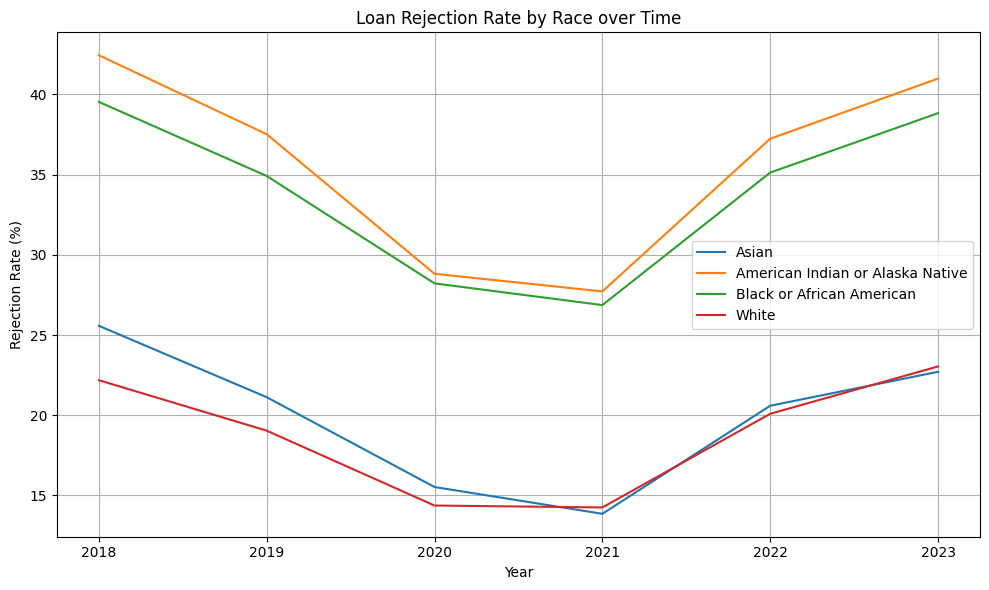

In [69]:
# Step 1: 清理 derived_race 字段
df["derived_race_clean"] = df["derived_race"].str.strip()

# Step 2: 定义我们关注的四个种族
target_races = [
    "Asian",
    "American Indian or Alaska Native",
    "Black or African American",
    "White"
]

# Step 3: 筛选出这四个种族的记录
df_filtered = df[df["derived_race_clean"].isin(target_races)]

# Step 4: 按 year 和 race 分组，计算拒绝率
grouped = (
    df_filtered
    .groupby(["activity_year", "derived_race_clean"])["rejected"]
    .mean()
    .reset_index()
    .rename(columns={"rejected": "reject_rate"})
)

# Step 5: 转为 Pandas（Dask不能直接画图）
result_pd = grouped.compute()

result_pd = (
    result_pd
    .groupby(["activity_year", "derived_race_clean"], as_index=False)["reject_rate"]
    .mean()
)

# Step 6: 画图
plt.figure(figsize=(10, 6))
for race in target_races:
    subset = result_pd[result_pd["derived_race_clean"] == race]
    plt.plot(subset["activity_year"], subset["reject_rate"] * 100, label=race)

plt.xlabel("Year")
plt.ylabel("Rejection Rate (%)")
plt.title("Loan Rejection Rate by Race over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [70]:
num_vars = ["loan_amount", "income", "rate_spread", "total_loan_costs", "property_value"]

# 先强制转换类型为 float64（兼容）
df_casted = df[num_vars].astype("float64")

# 再调用 describe（注意是 Dask 的）
desc_stats = df_casted.describe().compute()
print(desc_stats)


        loan_amount        income   rate_spread  total_loan_costs  \
count  8.023427e+07  7.486789e+07  5.764990e+07      4.883261e+07   
mean   2.867662e+05  1.685680e+02 -1.603645e+00      5.260115e+03   
std    2.596838e+07  1.006897e+05  4.562383e+03      6.091433e+05   
min    5.000000e+03 -7.110000e+05 -9.999997e+06      0.000000e+00   
25%    1.550000e+05  7.100000e+01  1.370000e-01      3.370305e+03   
50%    2.650000e+05  1.100000e+02  5.260000e-01      5.373500e+03   
75%    4.450000e+05  1.960000e+02  1.651000e+00      1.300252e+04   
max    2.323232e+11  7.175640e+08  4.456200e+04      4.256004e+09   

       property_value  
count    7.490552e+07  
mean     4.883578e+05  
std      3.173453e+06  
min      5.000000e+03  
25%      2.550000e+05  
50%      3.950000e+05  
75%      6.950000e+05  
max      2.147484e+09  


In [71]:
# 定义需要 log 的变量（不含 rate_spread）
vars_to_clean_and_log = ["loan_amount", "income", "total_loan_costs", "property_value"]

# 设置异常值裁剪上下分位数
lower_q = 0.01
upper_q = 0.99

# ⚠️ 分位数计算必须先 compute，所以先分别提取
for var in vars_to_clean_and_log:
    # 仅保留非负值
    df = df[df[var] >= 0]

    # 计算上下分位数（只采样部分数据防止内存问题）
    sample_series = df[var].sample(frac=0.1).compute()
    lower, upper = sample_series.quantile([lower_q, upper_q])

    # 裁剪异常值范围
    df = df[(df[var] >= lower) & (df[var] <= upper)]

    # 添加 log 列
    df[f"{var}_log"] = np.log1p(df[var])

# ➕ rate_spread 范围过滤（只保留 -1 到 3）
df = df[(df["rate_spread"] >= -1) & (df["rate_spread"] <= 3)]

# 检查新列名
print(df.columns)


Index(['activity_year', 'action_taken', 'rate_spread', 'total_loan_costs',
       'loan_amount', 'income', 'debt_to_income_ratio',
       'applicant_credit_score_type', 'applicant_age', 'derived_race',
       'derived_ethnicity', 'tract_minority_population_percent',
       'tract_to_msa_income_percentage', 'derived_msa_md', 'state_code',
       'county_code', 'census_tract', 'lei', 'loan_type',
       'derived_loan_product_type', 'applicant_sex', 'applicant_race_1',
       'applicant_ethnicity_1', 'co_applicant_race_1',
       'co_applicant_ethnicity_1', 'loan_purpose', 'loan_term',
       'interest_rate', 'property_value', 'occupancy_type', 'lien_status',
       'rejected', 'derived_race_clean', 'loan_amount_log', 'income_log',
       'total_loan_costs_log', 'property_value_log'],
      dtype='object')


In [72]:
# 定义变量组
target_races = ["Asian", "American Indian or Alaska Native", "Black or African American", "White"]
non_log_vars = ["rate_spread", "rejected"]
all_plot_vars = [f"{var}_log" for var in vars_to_clean_and_log] + non_log_vars

# 筛选目标种族
df_filtered = df[df["derived_race_clean"].isin(target_races)]

# 提取需要用于绘图的列
cols_needed = ["derived_race_clean"] + all_plot_vars
df_log_pd = df_filtered[cols_needed].compute()


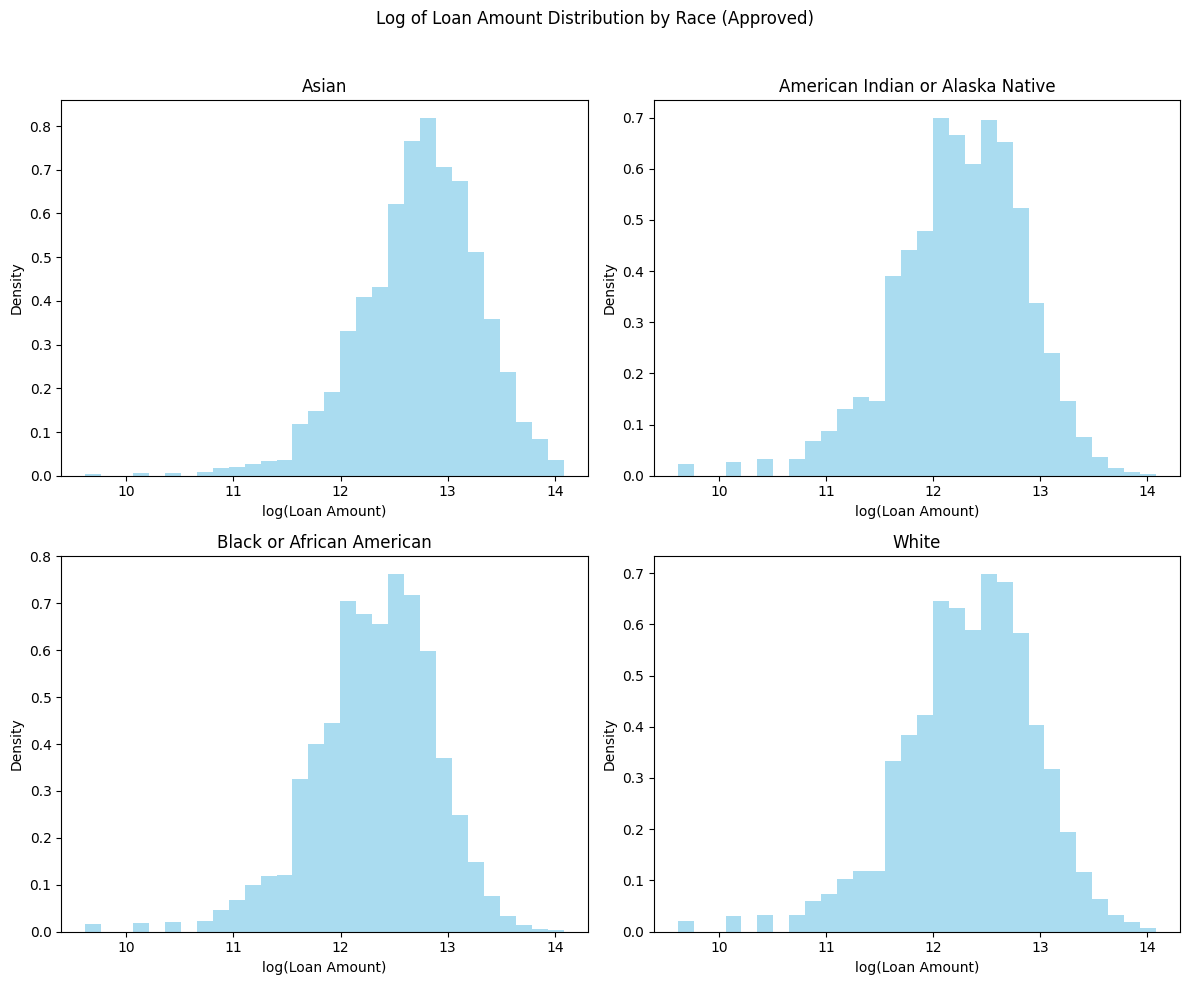

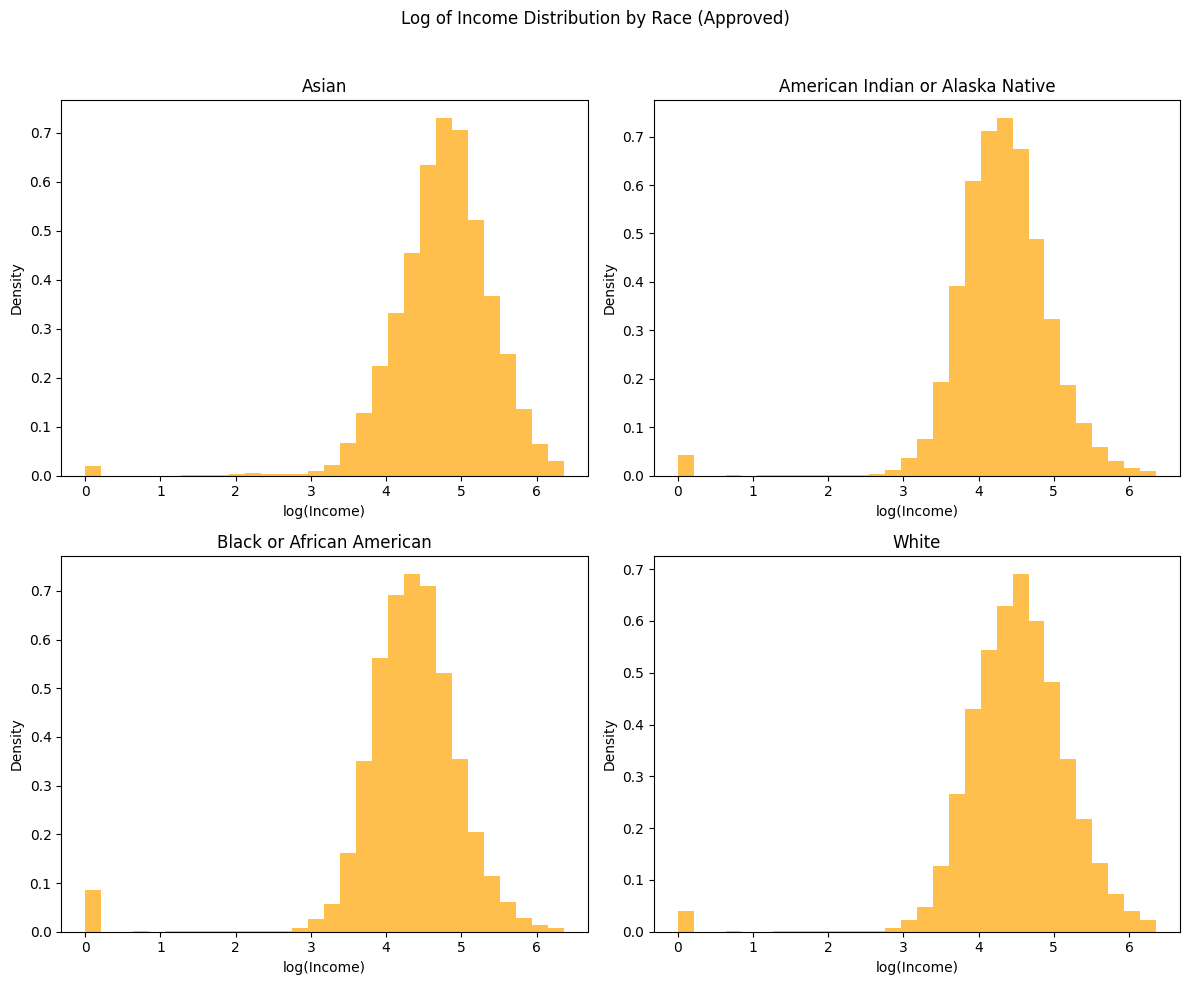

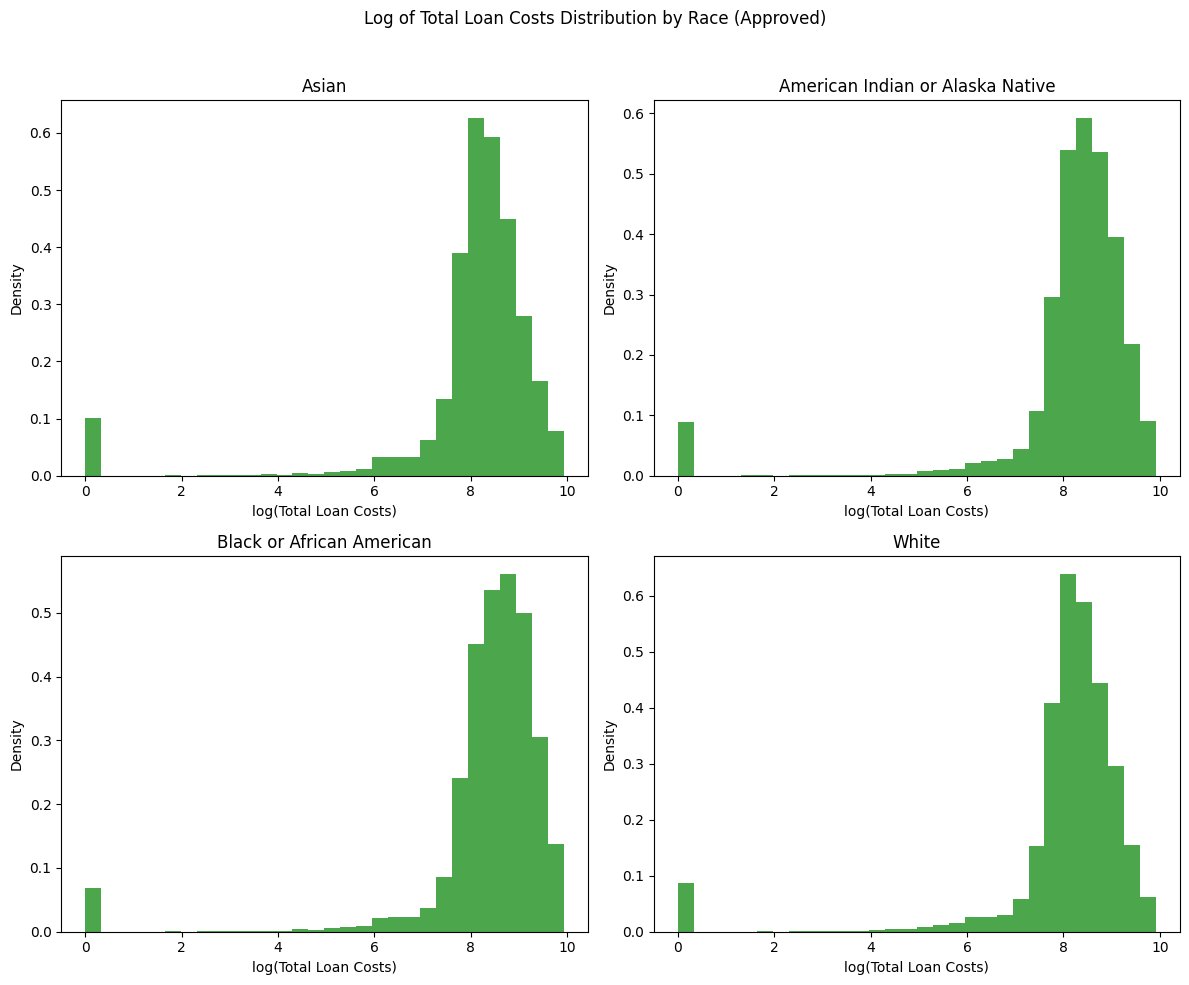

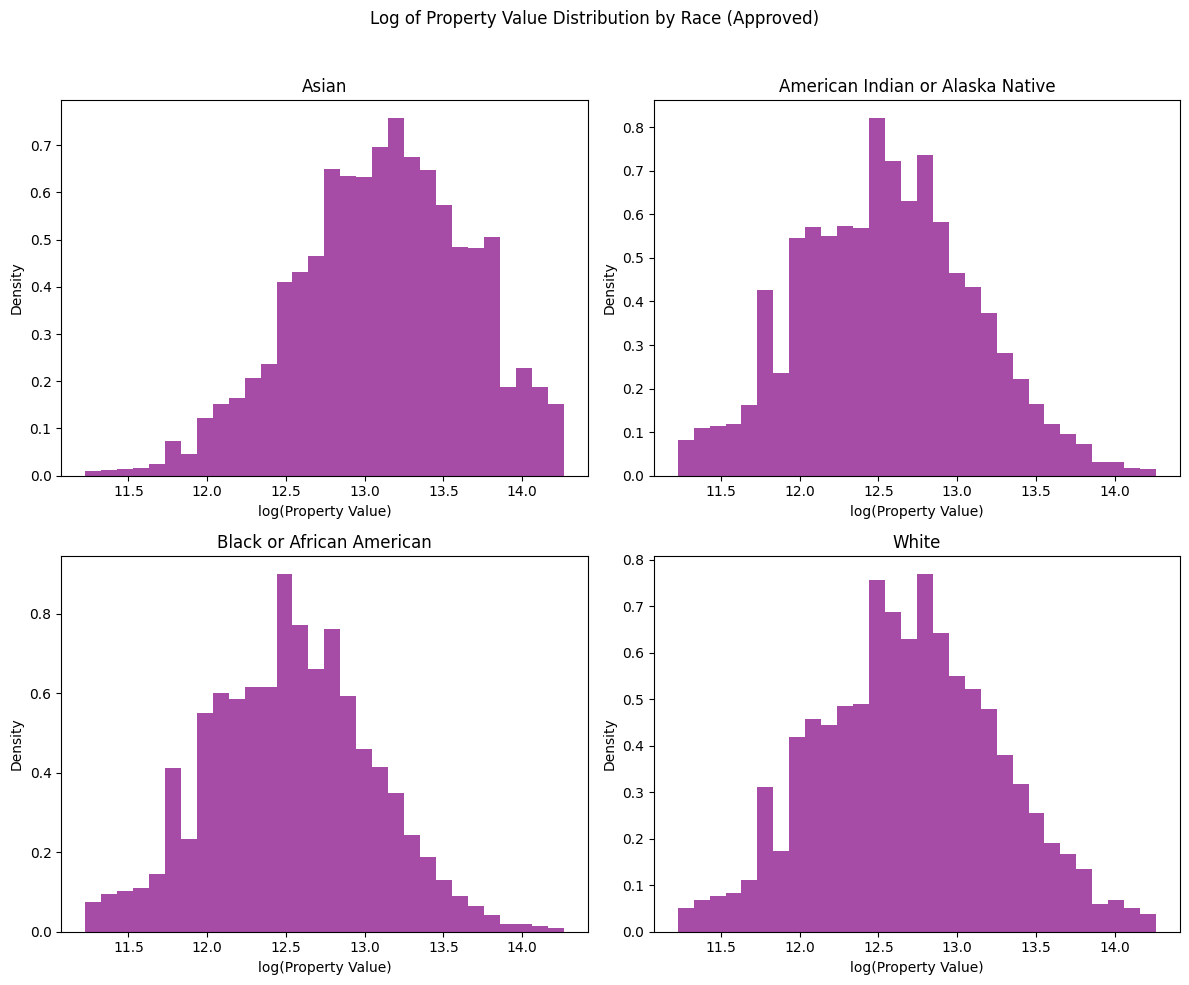

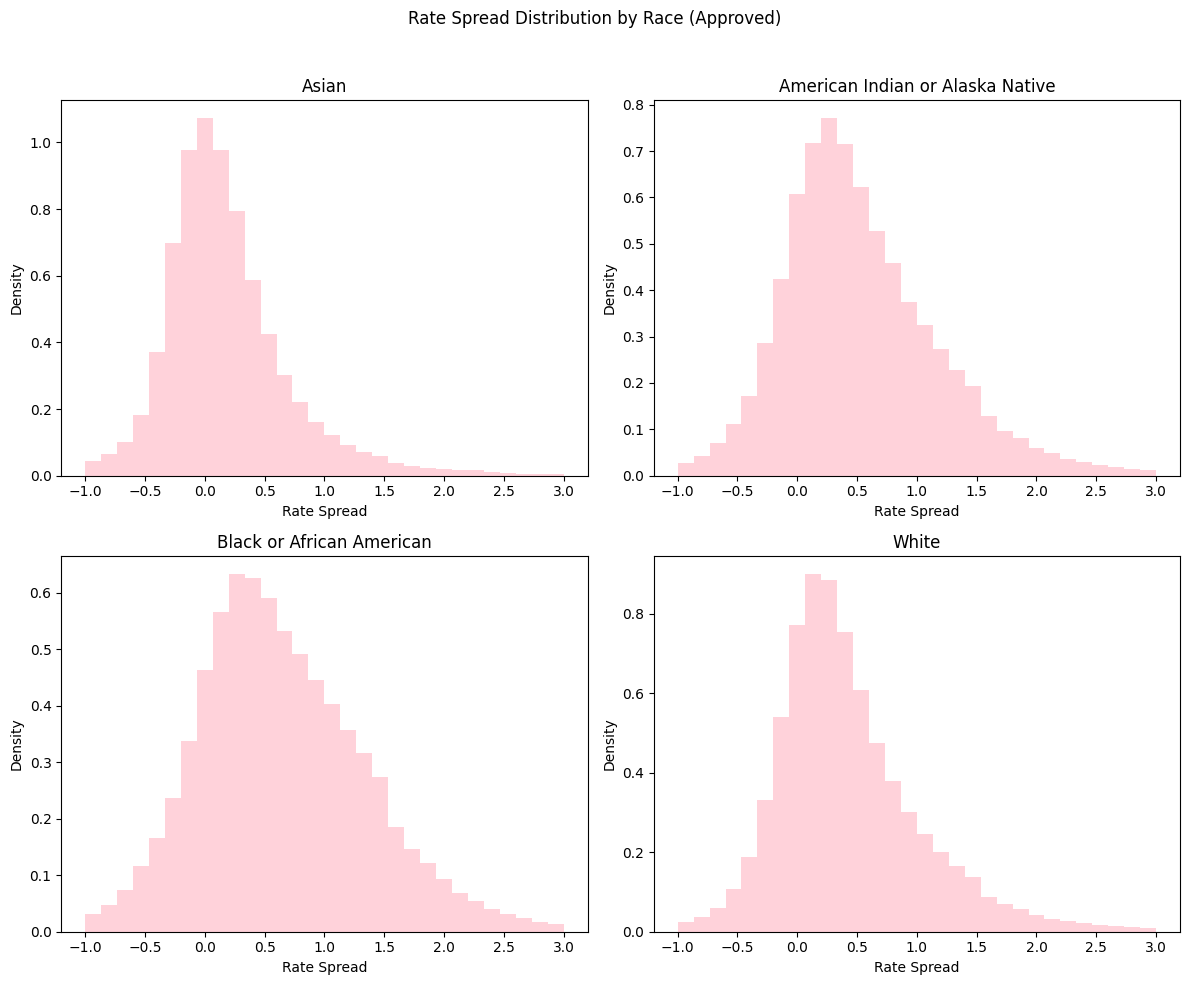

In [74]:
import matplotlib.pyplot as plt

# 颜色映射
color_map = {
    "loan_amount_log": "skyblue",
    "income_log": "orange",
    "total_loan_costs_log": "green",
    "property_value_log": "purple",
    "rate_spread": "pink"
}

# 封装函数：给定 rejected 状态，画一套图
def plot_by_race(filtered_df, rejected_value):
    group_label = "Rejected" if rejected_value == 1 else "Approved"
    df_subset = filtered_df[filtered_df["rejected"] == rejected_value]

    # ✅ 只画非 rejected 的变量
    plot_vars = [var for var in all_plot_vars if var != "rejected"]

    for var in plot_vars:
        var_title = var.replace("_log", "").replace("_", " ").title()
        fig, axs = plt.subplots(2, 2, figsize=(12, 10))
        fig.suptitle(f"{'Log of ' if '_log' in var else ''}{var_title} Distribution by Race ({group_label})")

        color = color_map.get(var, "gray")  # 默认灰色

        for i, race in enumerate(target_races):
            ax = axs[i // 2, i % 2]
            sub_pd = df_subset[df_subset["derived_race_clean"] == race][var].dropna()
            ax.hist(sub_pd, bins=30, alpha=0.7, color=color, density=True)
            ax.set_title(race)
            ax.set_xlabel(f"{'log(' if '_log' in var else ''}{var_title}{')' if '_log' in var else ''}")
            ax.set_ylabel("Density")

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

# ✅ 一遍 for rejected == 0
plot_by_race(df_log_pd, rejected_value=0)

In [80]:
df = dd.read_parquet('s3://nancyfinal/hmda_filtered_2018_2023.parquet')

# 定义要删除的 action_taken 值（字符串形式）
exclude_values = ['4', '5', '6', '-1']

# 删除这些值对应的行
df = df[~df["action_taken"].isin(exclude_values)]

# （可选）确认处理后唯一值
print(df["action_taken"].unique().compute())

df['rejected'] = df['action_taken'].isin(['3','7']).astype(int)

num_vars = ["income", "property_value"]

for col in num_vars:
    df[col] = dd.to_numeric(df[col], errors="coerce")

0    7
0    3
0    2
0    1
0    8
Name: action_taken, dtype: string


In [81]:
print(df["rejected"].unique().compute())

0    1
0    0
Name: rejected, dtype: int64


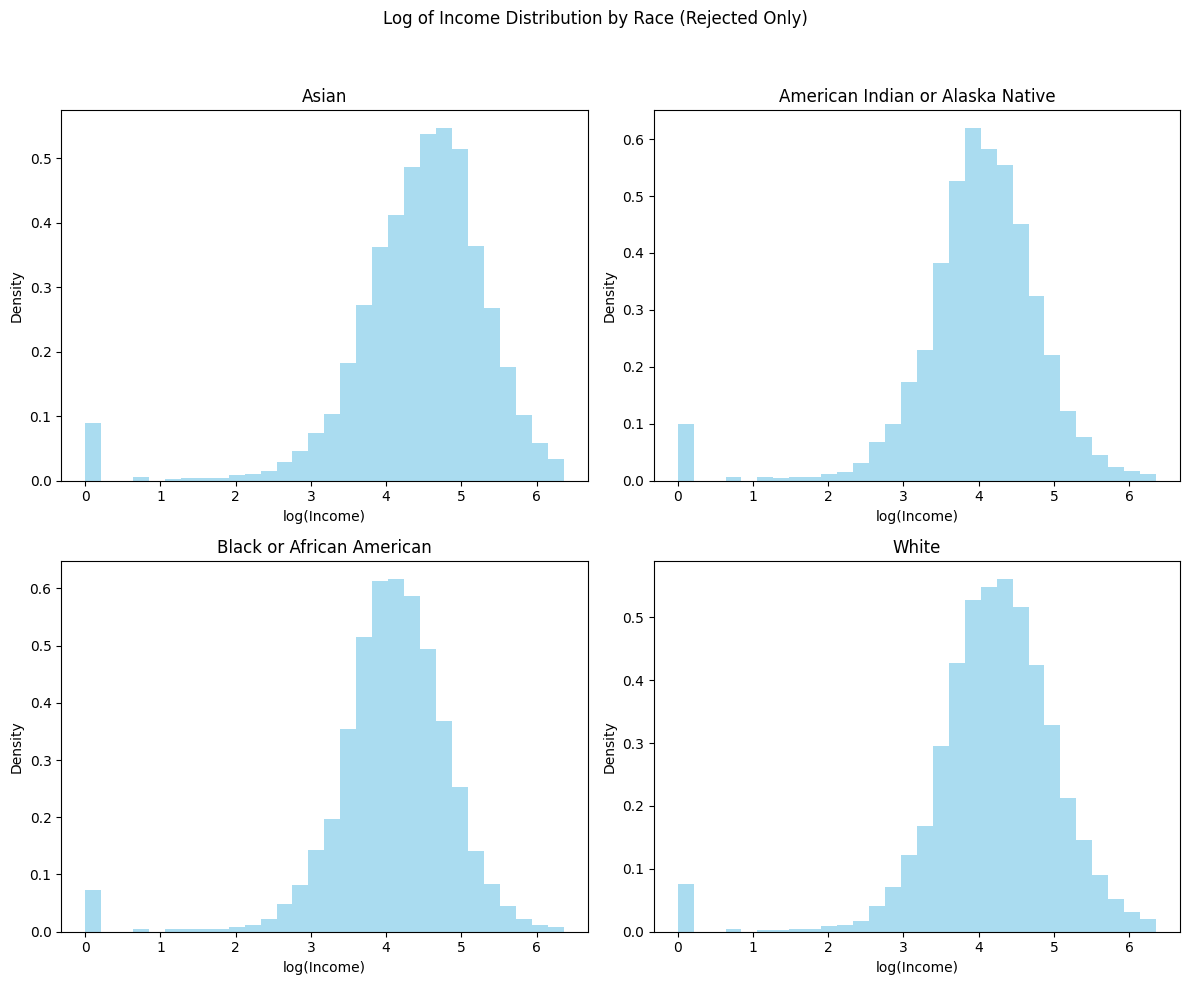

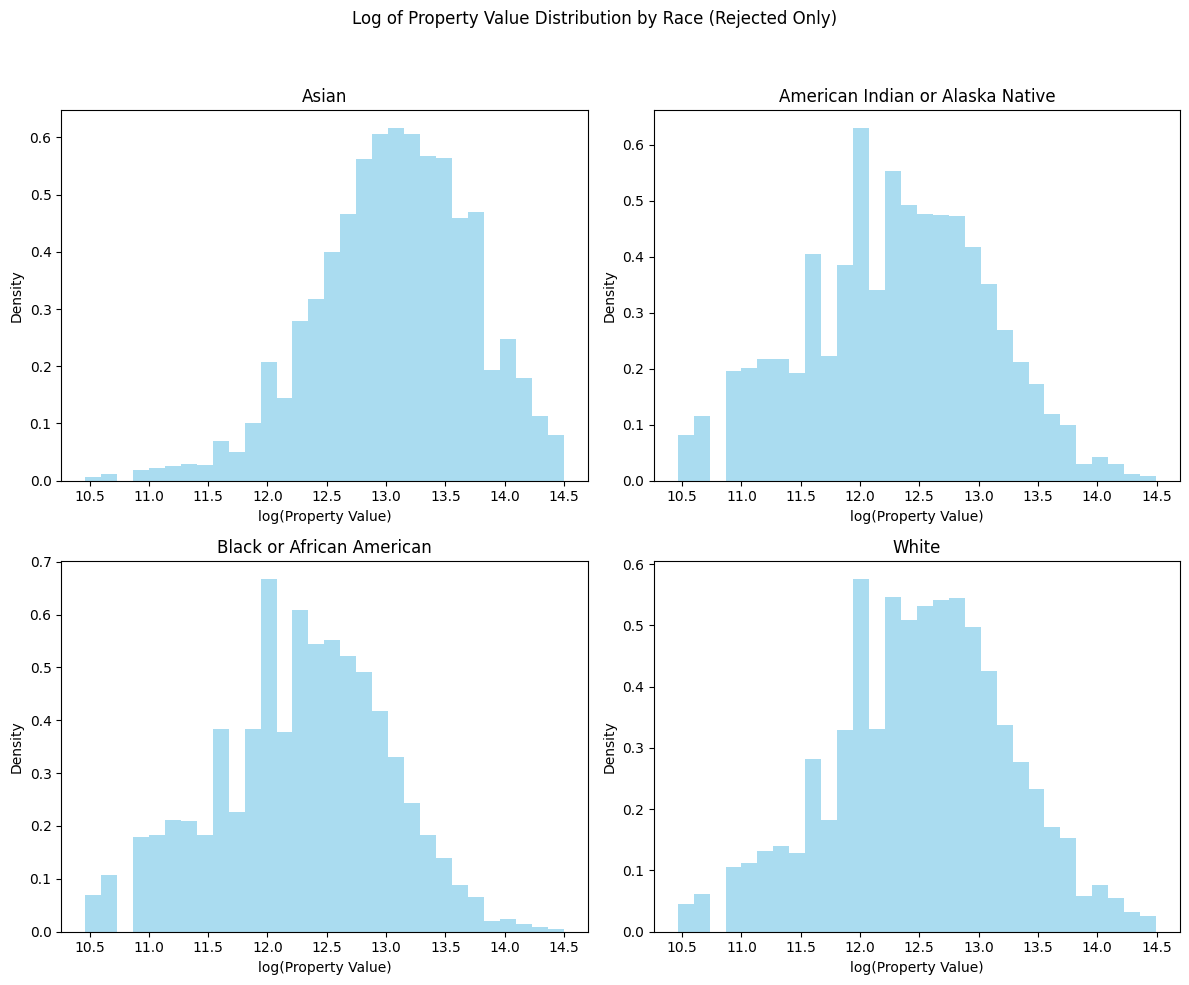

In [83]:
# 设置参数
target_races = ["Asian", "American Indian or Alaska Native", "Black or African American", "White"]
vars_to_clean_and_log = ["income", "property_value"]
lower_q = 0.01
upper_q = 0.99

# Step 1: 只保留被拒绝的记录 + 所需变量
df["derived_race_clean"] = df["derived_race"].str.strip()
df_reject = df[df["rejected"] == 1][["derived_race_clean"] + vars_to_clean_and_log]

# Step 2: 逐变量清洗 + log 转换
for var in vars_to_clean_and_log:
    df_reject = df_reject[df_reject[var] >= 0]  # 删除负值

    # 采样计算上下分位数
    sample_series = df_reject[var].sample(frac=0.1).compute()
    lower, upper = sample_series.quantile([lower_q, upper_q])

    # 剪裁极端值
    df_reject = df_reject[(df_reject[var] >= lower) & (df_reject[var] <= upper)]

    # 添加 log 变量列
    df_reject[f"{var}_log"] = np.log1p(df_reject[var])

# Step 3: 取回计算结果用于绘图
df_reject_pd = df_reject.compute()

# Step 4: 可视化 log(income) 和 log(property_value) 的种族分布图
for var in [f"{v}_log" for v in vars_to_clean_and_log]:
    var_title = var.replace("_log", "").replace("_", " ").title()
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f"Log of {var_title} Distribution by Race (Rejected Only)")

    for i, race in enumerate(target_races):
        ax = axs[i // 2, i % 2]
        sub_pd = df_reject_pd[df_reject_pd["derived_race_clean"] == race][var].dropna()
        ax.hist(sub_pd, bins=30, alpha=0.7, color="skyblue", density=True)
        ax.set_title(race)
        ax.set_xlabel(f"log({var_title})")
        ax.set_ylabel("Density")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [84]:
df.head(5)

,activity_year,action_taken,rate_spread,total_loan_costs,loan_amount,income,debt_to_income_ratio,applicant_credit_score_type,applicant_age,derived_race,...,co_applicant_race_1,co_applicant_ethnicity_1,loan_purpose,loan_term,interest_rate,property_value,occupancy_type,lien_status,rejected,derived_race_clean
0,2018,1,1.305,7822.87,135000,67,46,1,45-54,White,...,8,5,32,240,4.875,195000,1,1,0,White
1,2018,1,0.057,6859.57,235000,84,50%-60%,9,45-54,White,...,5,2,32,360,4.375,275000,1,1,0,White
2,2018,3,<NA>,<NA>,185000,45,>60%,3,35-44,White,...,5,2,32,360,<NA>,355000,1,1,1,White
3,2018,3,<NA>,<NA>,285000,78,42,1,35-44,White,...,8,5,31,360,<NA>,425000,1,1,1,White
4,2018,3,<NA>,<NA>,205000,36,>60%,1,25-34,White,...,8,5,32,360,<NA>,265000,1,1,1,White


In [86]:
print(df.dtypes)

activity_year                        string[pyarrow]
action_taken                         string[pyarrow]
rate_spread                          string[pyarrow]
total_loan_costs                     string[pyarrow]
loan_amount                          string[pyarrow]
income                                         Int64
debt_to_income_ratio                 string[pyarrow]
applicant_credit_score_type          string[pyarrow]
applicant_age                        string[pyarrow]
derived_race                         string[pyarrow]
derived_ethnicity                    string[pyarrow]
tract_minority_population_percent    string[pyarrow]
tract_to_msa_income_percentage       string[pyarrow]
derived_msa_md                       string[pyarrow]
state_code                           string[pyarrow]
county_code                          string[pyarrow]
census_tract                         string[pyarrow]
lei                                  string[pyarrow]
loan_type                            string[py

In [87]:
df.to_parquet("s3://nancyfinal/hmda_cleaned0529.parquet", engine="pyarrow", write_index=False)

In [19]:
cluster.close()

Terminated dask-977ae8db-worker-f5f765c3 (i-034296b50f086e70d)
Terminated dask-977ae8db-worker-970fe38e (i-062280cd75b51ce26)
Terminated dask-977ae8db-worker-e398203d (i-0ab59a29b0387fdcc)
Terminated dask-977ae8db-worker-3ddc7136 (i-0277bbd8eeeb38f81)
Terminated dask-977ae8db-scheduler (i-06d2ed2d86a48d8df)
